In [1]:
%load_ext autoreload
%autoreload 2
from AnalysisTables.location_times import LocationTimesParams, LocationTimesSelection, LocationTimes
import numpy as np
from spyglass.position.position_merge import PositionOutput

[2024-12-16 15:44:41,332][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-12-16 15:44:41,374][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[15:44:45][ERROR] Spyglass: Schema prefix not in SHARED_MODULES: ms_locations


# Populate

In [20]:
LocationTimesParams()

params_name = 'ms_wtrack_2023_choice_point'
centers = [np.array([68,125])]
radii = [20]
params_key = {"location_params_name": params_name,
              "centers": centers,
              "radii": radii}
LocationTimesParams().insert1(params_key, skip_duplicates=True)

params_name = 'ms_wtrack_choice_point'
centers = [np.array([85, 120])]
radii = [20]
params_key = {"location_params_name": params_name,
              "centers": centers,
              "radii": radii}
LocationTimesParams().insert1(params_key, skip_duplicates=True)


In [21]:
# dlc_key = {'dlc_si_cohort_centroid': 'WhiteLED', 'nwb_file_name': 'Bilbo20230802_.nwb', 'epoch': 2, 'video_file_num': 1, 'project_name': 'Wtrack_WhiteLED_FB', 'dlc_model_name': 'Wtrack_WhiteLED_FB_wtrack_whiteled_FB_01', 'dlc_model_params_name': 'default', 'dlc_centroid_params_name': 'whiteLED_centroid_smooth_interp_fixed2', 'dlc_si_cohort_orientation': 'WhiteLED', 'dlc_orientation_params_name': 'none'}
PositionOutput().DLCPosV1() & {'project_name': 'Wtrack_WhiteLED_FB'}
for merge_key in (PositionOutput().DLCPosV1() & {'project_name': 'Wtrack_WhiteLED_FB'}).fetch("KEY"):
    insert_key = {**merge_key,"location_params_name":'ms_wtrack_2023_choice_point'}
    LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

PositionOutput().DLCPosV1() & {'project_name': 'Wtrack_WhiteLED'}
for merge_key in (PositionOutput().DLCPosV1() & {'project_name': 'Wtrack_WhiteLED'}).fetch("KEY"):
    insert_key = {**merge_key,"location_params_name":'ms_wtrack_choice_point'}
    LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

# merge_key = (PositionOutput().DLCPosV1() & dlc_key).fetch1("KEY")
# insert_key = {**merge_key,"location_params_name": params_name}
# LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

In [22]:
LocationTimes().populate()

{'success_count': 88, 'error_list': []}

[[1.4000022411346436],
 [0.7999868392944336],
 [2.799973249435425],
 [1.0666530132293701],
 [0.866657018661499],
 [0.9999983310699463],
 [0.9999980926513672],
 [0.7999858856201172],
 [0.6999900341033936],
 [0.8333320617675781],
 [0.8666565418243408],
 [0.90000319480896],
 [0.8666565418243408],
 [0.8999814987182617],
 [0.8999829292297363],
 [0.833331823348999],
 [0.7666614055633545],
 [0.7666614055633545],
 [1.033323049545288],
 [0.7666594982147217],
 [0.9333248138427734],
 [0.8333320617675781],
 [0.9333271980285645],
 [0.7999861240386963],
 [0.69999098777771],
 [1.333310604095459],
 [0.8333323001861572],
 [0.6999897956848145],
 [0.7666609287261963],
 [0.7333147525787354],
 [1.0999975204467773],
 [0.7999861240386963],
 [0.6999905109405518],
 [0.7666666507720947],
 [2.0333261489868164],
 [3.3999648094177246],
 [0.9666523933410645],
 [1.266660213470459],
 [0.93332839012146],
 [1.0999948978424072],
 [0.8666572570800781],
 [5.499926805496216],
 [0.9999988079071045],
 [0.7333400249481201],
 

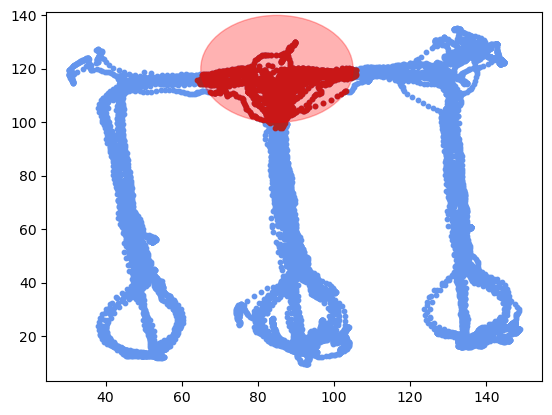

In [24]:
LocationTimes().validate_location(insert_key)

intervals = (LocationTimes() & insert_key).fetch1("intervals")
[[en-st] for st,en in intervals]


# Analyze

In [56]:
from Analysis.utils import filter_opto_data,violin_scatter
from AnalysisTables.trial_intervals import TrialIntervals
from spyglass.common import TaskEpoch, PositionIntervalMap
from Style.style_guide import animal_style
import matplotlib.pyplot as plt
# from spyglass.position.v1 import

datasets: 9
datasets: 9
datasets: 10
datasets: 16
datasets: 10
datasets: 8
datasets: 16
datasets: 8
datasets: 9
datasets: 9
datasets: 10
datasets: 16
datasets: 10
datasets: 8
datasets: 16
datasets: 8


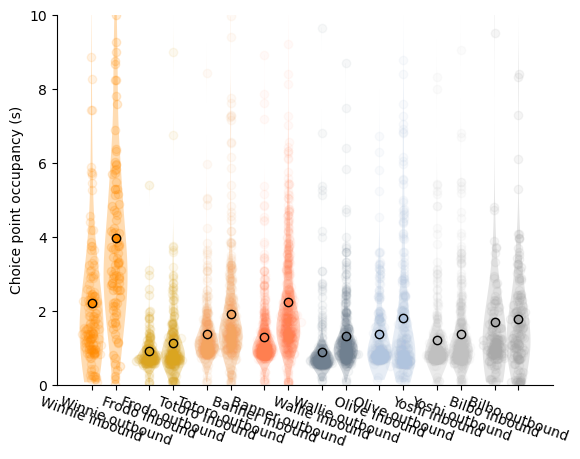

In [80]:
# animal = 'Bilbo'
animal_list = list(animal_style.index)
animal_list = [a for a in animal_list if a not in ["Odins","control","transfected"]]

# animal_list = ["control","transfected"]


pos_list = []
labels_list = []
fig = plt.figure()
ax = fig.add_subplot(111)
for i_trial, trial_type in enumerate(["inbound","outbound"]):
    for i, animal in enumerate(animal_list):
        dataset_key = {"animal": animal,"track_type":"early_wtrack"}
        dataset = filter_opto_data(dataset_key)

        if not dataset:
            continue
        occupancy_lengths = []
        for key in dataset.fetch("KEY"):
            epoch_key = {
                            "nwb_file_name": key["nwb_file_name"],
                            "position_interval_name": key["interval_list_name"],
                        }
            epoch = ((PositionIntervalMap() & epoch_key) * TaskEpoch()).fetch1("epoch")

            query = PositionOutput.DLCPosV1() & key & {"epoch": epoch}
            if not query:
                continue
            # request_table = LocationTimes()
            # request_table.ban_search_table(PositionOutput.CommonPos())
            # request_table << {"nwb_file_name": "Bilbo20230802_.nwb",}
            intervals = (LocationTimes() & query).fetch1("intervals")

            trial_query = TrialIntervals() & {"nwb_file_name":key["nwb_file_name"],
                                                    "epoch":epoch,}
            trial_interval = None
            if trial_type == "outbound":
                # if not trial_query:
                #     continue
                trial_interval = trial_query.fetch1("outbound_trial_intervals")
            elif trial_type == "inbound":
                # if not trial_query:
                #     continue
                trial_interval = trial_query.fetch1("inbound_trial_intervals")

            if not len(trial_interval):
                continue
            intervals = interval_list_intersect(intervals,trial_interval)

            occupancy_lengths.extend([en-st for st,en in intervals])

        pos = i*1.2+i_trial*.5
        violin_scatter(occupancy_lengths,pos=pos,color=animal_style.loc[animal,"color"],mark_mean=True)
        plt.scatter([pos],[np.mean(occupancy_lengths)],color=animal_style.loc[animal,"color"],edgecolor="k",label=animal+" "+trial_type)
        pos_list.append(pos)
        labels_list.append(animal+" "+trial_type)
plt.ylim(0, 10)
plt.xticks(pos_list,labels_list,rotation=-20)
plt.ylabel("Choice point occupancy (s)")
ax.spines[['top', 'right']].set_visible(False)

In [61]:
trial_type = "outbound"

trial_query = TrialIntervals() & {"nwb_file_name":key["nwb_file_name"],
                                                "epoch":epoch,}
trial_interval = None
if trial_type == "outbound":
    # if not trial_query:
    #     continue
    trial_interval = trial_query.fetch1("outbound_trial_intervals")
elif trial_type == "inbound":
    # if not trial_query:
    #     continue
    trial_interval = trial_query.fetch1("inbound_trial_intervals")
# if interval is not None:
#     ind = interval_list_contains_ind(interval, pos_df.index.values)
#     # linear_df = linear_df.iloc[ind]
#     pos_df = pos_df.iloc[ind]

In [63]:
from spyglass.common import interval_list_intersect

# interval_list_intersect(trial_interval, intervals)
trial_interval

array([], shape=(0, 2), dtype=float64)